# **Stock Price Prediction Using Simple RNN**

### Importing Libraries

In [30]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import random as python_random
from tensorflow.keras.layers import Input
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
from keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import plotly.express as px

In [31]:
# Fix random seed for reproducibility
np.random.seed(1)
python_random.seed(1)
tf.random.set_seed(1)

### Data Collection




In [32]:
# Download the historical stock price data for Apple
hist_data = yf.download('AAPL','2015-01-02','2019-12-31')
hist_data.index = pd.to_datetime(hist_data.index)
hist_data

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,27.847500,27.860001,26.837500,27.332500,24.373962,212818400
2015-01-05,27.072500,27.162500,26.352501,26.562500,23.687309,257142000
2015-01-06,26.635000,26.857500,26.157499,26.565001,23.689537,263188400
2015-01-07,26.799999,27.049999,26.674999,26.937500,24.021713,160423600
2015-01-08,27.307501,28.037500,27.174999,27.972500,24.944685,237458000
...,...,...,...,...,...,...
2019-12-23,70.132500,71.062500,70.092499,71.000000,68.908981,98572000
2019-12-24,71.172501,71.222504,70.730003,71.067497,68.974487,48478800
2019-12-26,71.205002,72.495003,71.175003,72.477501,70.342979,93121200


### Data Preprocessing

In [33]:
# Checking for missing values
print(hist_data.isnull().sum())

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [34]:
# Filling missing dates
date_range = pd.date_range(start='2015-01-02', end='2019-12-30', freq='D')
hist_data = hist_data.reindex(date_range)
hist_data= hist_data.interpolate(method='linear')
hist_data.dropna()
hist_data.head(15)

,Open,High,Low,Close,Adj Close,Volume
2015-01-02,27.847500,27.860001,26.837500,27.332500,24.373962,2.128184e+08
2015-01-03,27.589167,27.627501,26.675833,27.075834,24.145078,2.275929e+08
2015-01-04,27.330833,27.395000,26.514167,26.819167,23.916194,2.423675e+08
2015-01-05,27.072500,27.162500,26.352501,26.562500,23.687309,2.571420e+08
2015-01-06,26.635000,26.857500,26.157499,26.565001,23.689537,2.631884e+08
2015-01-07,26.799999,27.049999,26.674999,26.937500,24.021713,1.604236e+08
2015-01-08,27.307501,28.037500,27.174999,27.972500,24.944685,2.374580e+08
2015-01-09,28.167500,28.312500,27.552500,28.002501,24.971432,2.147980e+08
2015-01-10,28.161666,28.260833,27.435000,27.772500,24.766329,2.093997e+08
2015-01-11,28.155833,28.209166,27.317500,27.542500,24.561226,2.040015e+08


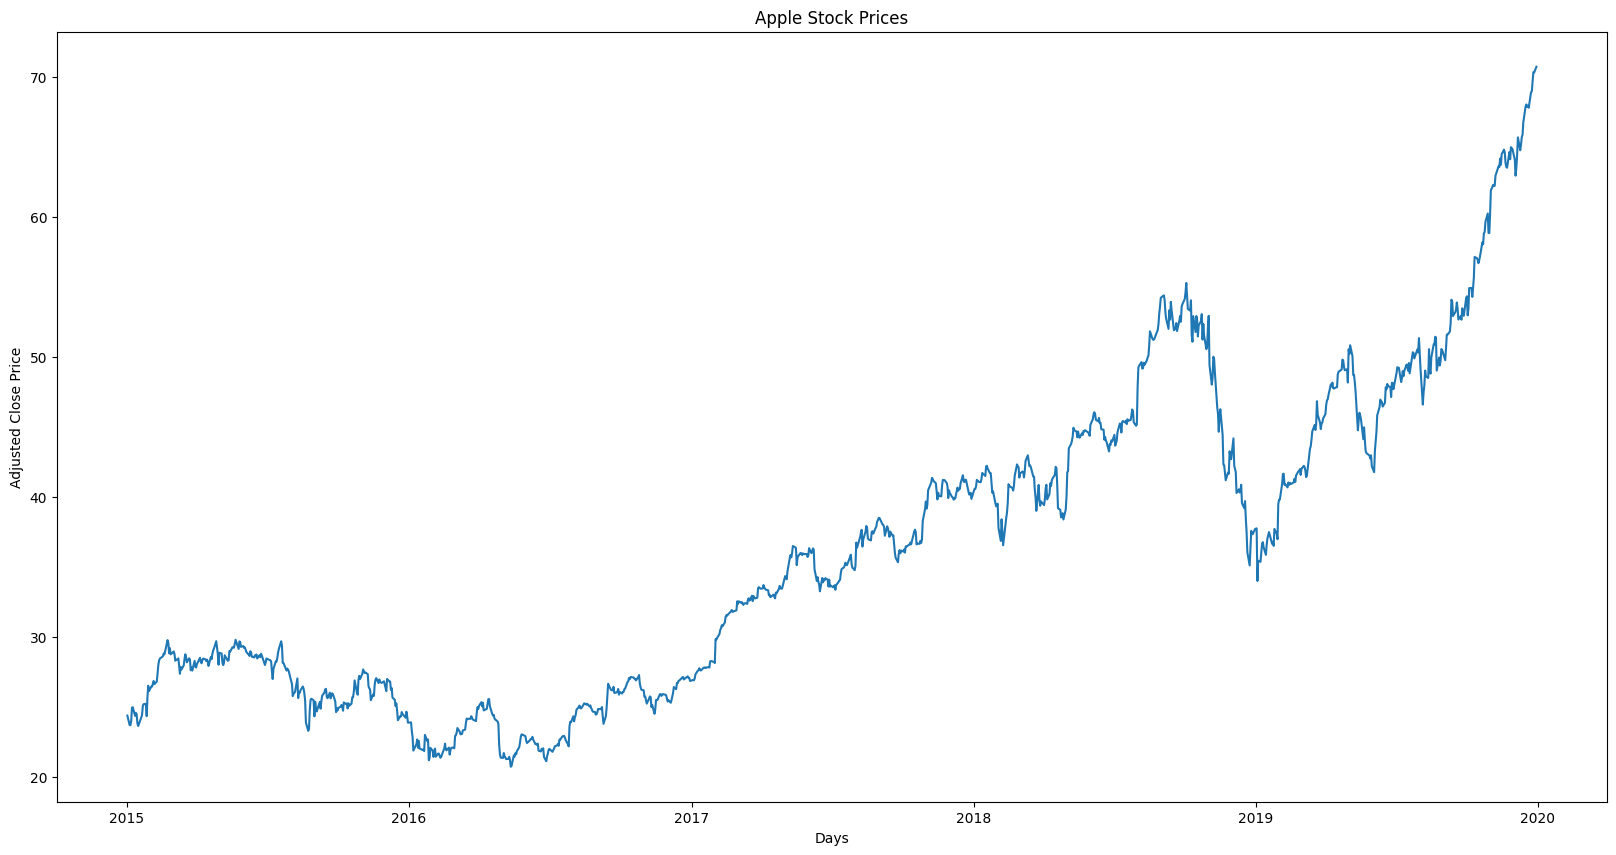

In [35]:
# Plot historical stock data
plt.figure(figsize=(20, 10))
plt.xlabel('Days')
plt.ylabel('Adjusted Close Price')
plt.title('Apple Stock Prices')
plt.plot(hist_data['Adj Close'])
plt.show()

### Splitting data



In [36]:
hist_data_length = len(hist_data)
train_split_ratio = 0.7
valid_split_ratio = 0.85
train_data_length = round(hist_data_length * train_split_ratio)
valid_data_length = round(hist_data_length * valid_split_ratio)

In [37]:
train_hist_data_close_values = hist_data[:train_data_length].iloc[:,4:5]
train_hist_data_close_values

,Adj Close
2015-01-02,24.373962
2015-01-03,24.145078
2015-01-04,23.916194
2015-01-05,23.687309
2015-01-06,23.689537
...,...
2018-06-27,43.716255
2018-06-28,44.034340
2018-06-29,43.941769
2018-06-30,44.105563


In [38]:
valid_hist_data_close_values = hist_data[train_data_length:valid_data_length].iloc[:,4:5]
valid_hist_data_close_values.shape

(273, 1)

In [39]:
test_hist_data_close_values = hist_data[valid_data_length:].iloc[:,4:5]
test_hist_data_close_values.shape

(274, 1)

### Normalising data

In [40]:
scaler = MinMaxScaler(feature_range=(0,1))
train_hist_data_close_scaled = scaler.fit_transform(train_hist_data_close_values)
valid_hist_data_close_scaled = scaler.transform(valid_hist_data_close_values)
test_hist_data_close_scaled = scaler.transform(test_hist_data_close_values)

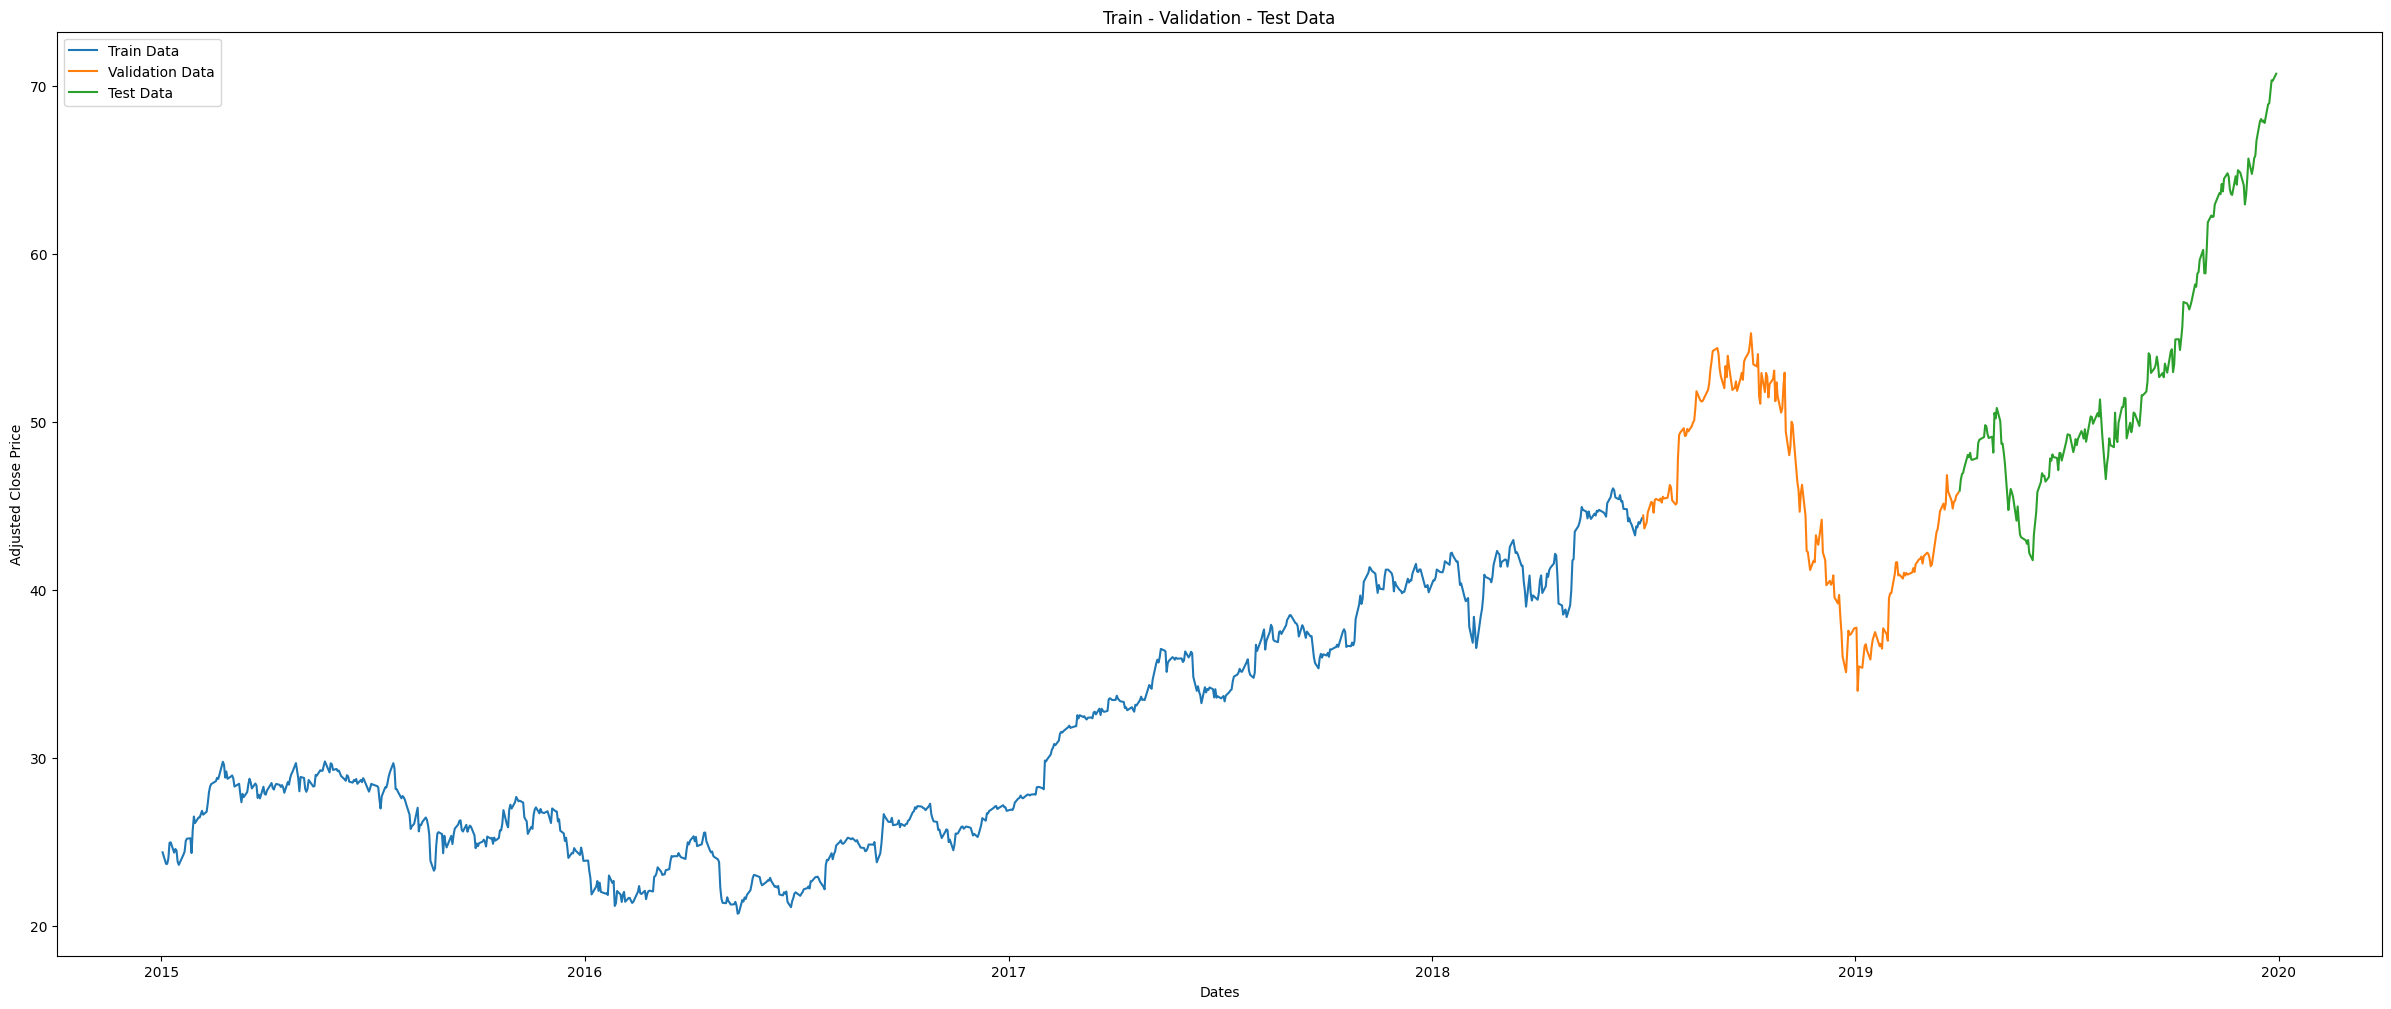

In [41]:
# Plot the splitting data
plt.subplots(figsize =(30,12))
plt.plot(train_hist_data_close_values.index ,train_hist_data_close_values, label = "Train Data")
plt.plot(valid_hist_data_close_values.index ,valid_hist_data_close_values, label = "Validation Data")
plt.plot(test_hist_data_close_values.index, test_hist_data_close_values, label = "Test Data",)
plt.xlabel("Dates")
plt.ylabel("Adjusted Close Price")
plt.title("Train - Validation - Test Data")
plt.legend()
plt.show()

### Sequence Creation

In [42]:
def create_sequence(data, time_step):
    X, Y = [], []
    for i in range(time_step, len(data)):
        X.append(data[i-time_step:i,0])
        Y.append(data[i,0])
    return np.array(X), np.array(Y)

In [43]:
time_step = 50
X_train, Y_train = create_sequence(train_hist_data_close_scaled,time_step)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
Y_train = np.reshape(Y_train, (Y_train.shape[0],1))

In [44]:
X_valid, Y_valid = create_sequence(valid_hist_data_close_scaled,time_step)
X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1],1))
Y_valid = np.reshape(Y_valid, (Y_valid.shape[0],1))

In [45]:
X_test, Y_test = create_sequence(test_hist_data_close_scaled,time_step)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
Y_test = np.reshape(Y_test, (Y_test.shape[0],1))

### Building the RNN model

In [46]:
rnn_model = Sequential()
rnn_model.add(Input(shape=(X_train.shape[1], 1)))
rnn_model.add(SimpleRNN(80, activation = "tanh", return_sequences=True))
rnn_model.add(Dropout(0.2))
rnn_model.add(SimpleRNN(80, activation = "tanh", return_sequences=False))
rnn_model.add(Dropout(0.2))
rnn_model.add(Dense(1))
rnn_model.compile(optimizer='adam', loss='mean_squared_error')
rnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_2 (SimpleRNN)             │ (None, 50, 80)              │           6,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 50, 80)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_3 (SimpleRNN)             │ (None, 80)                  │          12,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 80)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              81 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,521 (76.25 KB)

 Trainable params: 19,521 (76.25 KB)

 Non-trainable params: 0 (0.00 B)

In [47]:
# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True)
rnn_model_history = rnn_model.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), batch_size=32, epochs=100, callbacks=[early_stopping])

Epoch 1/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 75ms/step - loss: 0.1859 - val_loss: 0.0102
Epoch 2/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0271 - val_loss: 0.0061
Epoch 3/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0156 - val_loss: 0.0067
Epoch 4/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0109 - val_loss: 0.0050
Epoch 5/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0108 - val_loss: 0.0038
Epoch 6/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0074 - val_loss: 0.0044
Epoch 7/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0069 - val_loss: 0.0027
Epoch 8/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0061 - val_loss: 0.0032
Epoch 9/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0051 - val_loss: 0.0026
Epoch 10/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0054 - val_loss: 0.0074
Epoch 11/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0045 - val_loss: 0.0032
Epoch 12/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step

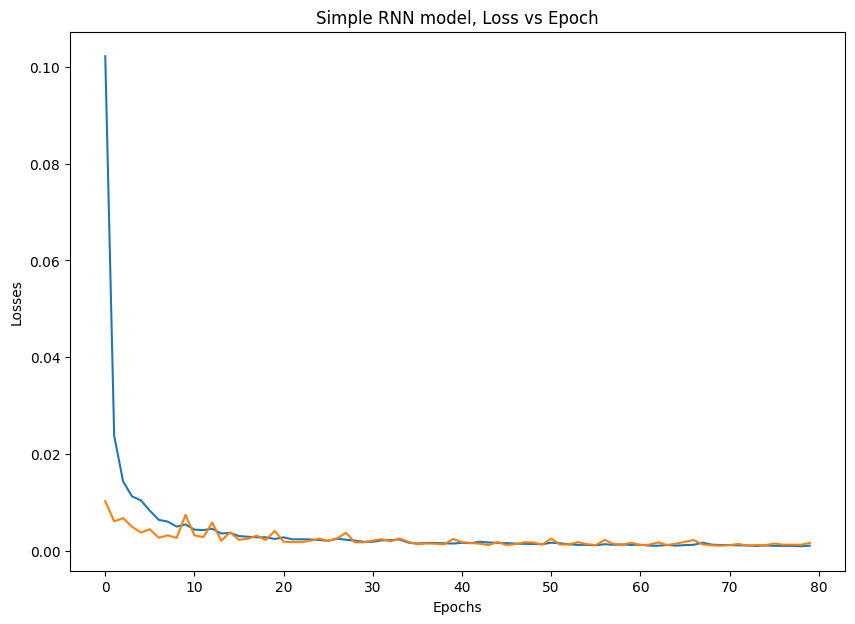

In [48]:
# Plot Loss vs Epoch
plt.figure(figsize =(10,7))
plt.plot(rnn_model_history.history["loss"], label='Training Loss')
plt.plot(rnn_model_history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("Simple RNN model, Loss vs Epoch")
plt.show()

### Model Prediction

In [49]:
Y_pred_train = rnn_model.predict(X_train)
Y_pred_valid = rnn_model.predict(X_valid)
Y_test_pred = rnn_model.predict(X_test)

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


In [50]:
# Scaling back to original value
Y_pred_train = scaler.inverse_transform(Y_pred_train)
Y_pred_valid = scaler.inverse_transform(Y_pred_valid)
Y_test_pred = scaler.inverse_transform(Y_test_pred)
Y_train = scaler.inverse_transform(Y_train)
Y_valid = scaler.inverse_transform(Y_valid)
Y_test = scaler.inverse_transform(Y_test)

### Residual Analysis

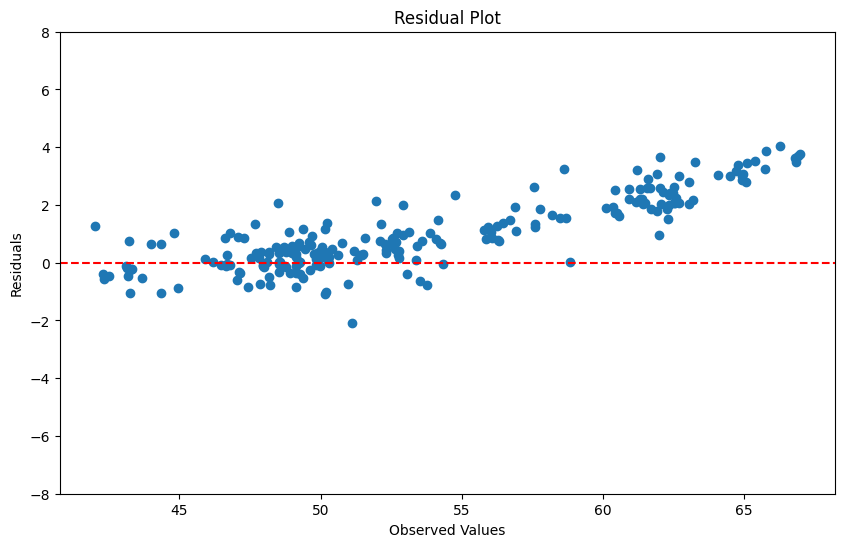

In [51]:
# Calculate residuals
residuals = Y_test - Y_test_pred

# Plot residuals
plt.figure(figsize=(10, 6))
plt.scatter(Y_test_pred, residuals)
plt.title('Residual Plot')
plt.xlabel('Observed Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.ylim([-8, 8])
plt.show()

### Error Metrics Calculations

In [52]:
# Error Metrics for RNN Model
mse_rnn_train = round(mean_squared_error(Y_train, Y_pred_train),2)
mae_rnn_train = round(mean_absolute_error(Y_train, Y_pred_train),2)
mape_rnn_train = round((mean_absolute_percentage_error(Y_train, Y_pred_train)*100),2)
r2_rnn_train = round((r2_score(Y_train, Y_pred_train)*100),2)

mse_rnn_valid = round(mean_squared_error(Y_valid, Y_pred_valid),2)
mae_rnn_valid = round(mean_absolute_error(Y_valid, Y_pred_valid),2)
mape_rnn_valid = round((mean_absolute_percentage_error(Y_valid, Y_pred_valid)*100),2)
r2_rnn_valid = round((r2_score(Y_valid, Y_pred_valid)*100),2)

mse_rnn_test = round(mean_squared_error(Y_test, Y_test_pred),2)
mae_rnn_test = round(mean_absolute_error(Y_test, Y_test_pred),2)
mape_rnn_test = round((mean_absolute_percentage_error(Y_test, Y_test_pred)*100),2)
r2_rnn_test = round((r2_score(Y_test, Y_test_pred)*100),2)

# Printing Results
print("RNN Model Training Metrics:")
print("MSE:", mse_rnn_train, "MAE:", mae_rnn_train, "MAPE:", mape_rnn_train, "Accuracy(R2 Score):", r2_rnn_train)
print("RNN Model Validation Metrics:")
print("MSE:", mse_rnn_valid, "MAE:", mae_rnn_valid, "MAPE:", mape_rnn_valid, "Accuracy(R2 Score):", r2_rnn_valid)
print("RNN Model Testing Metrics:")
print("MSE:", mse_rnn_test, "MAE:", mae_rnn_test, "MAPE:", mape_rnn_test, "Accuracy(R2 Score):", r2_rnn_test)

RNN Model Training Metrics:
MSE: 0.15 MAE: 0.27 MAPE: 0.89 Accuracy(R2 Score): 99.68
RNN Model Validation Metrics:
MSE: 0.66 MAE: 0.59 MAPE: 1.33 Accuracy(R2 Score): 98.26
RNN Model Testing Metrics:
MSE: 2.44 MAE: 1.17 MAPE: 1.96 Accuracy(R2 Score): 95.84


In [53]:
# Plot the bar chart for errors
data = {
    'Phase': ['Training', 'Validation', 'Testing'],
    'MSE': [mse_rnn_train, mse_rnn_valid, mse_rnn_test],
    'MAE': [mae_rnn_train, mae_rnn_valid, mae_rnn_test],
    'MAPE': [mape_rnn_train, mape_rnn_valid, mape_rnn_test],
}
df = pd.DataFrame(data)
df_long = pd.melt(df, id_vars='Phase', var_name='Metric', value_name='Value')
fig = px.bar(
    data_frame=df_long,
    x='Metric',
    y='Value',
    color='Phase',
    barmode='group',
    title='RNN Model: Error Metrics Across Phases',
    color_discrete_sequence=px.colors.qualitative.Plotly
)
fig.update_layout(
    xaxis_title='Metric',
    yaxis_title='Value',
    legend_title='Phase',
    yaxis=dict(showgrid=True)
)
fig.show()

### Visualisation

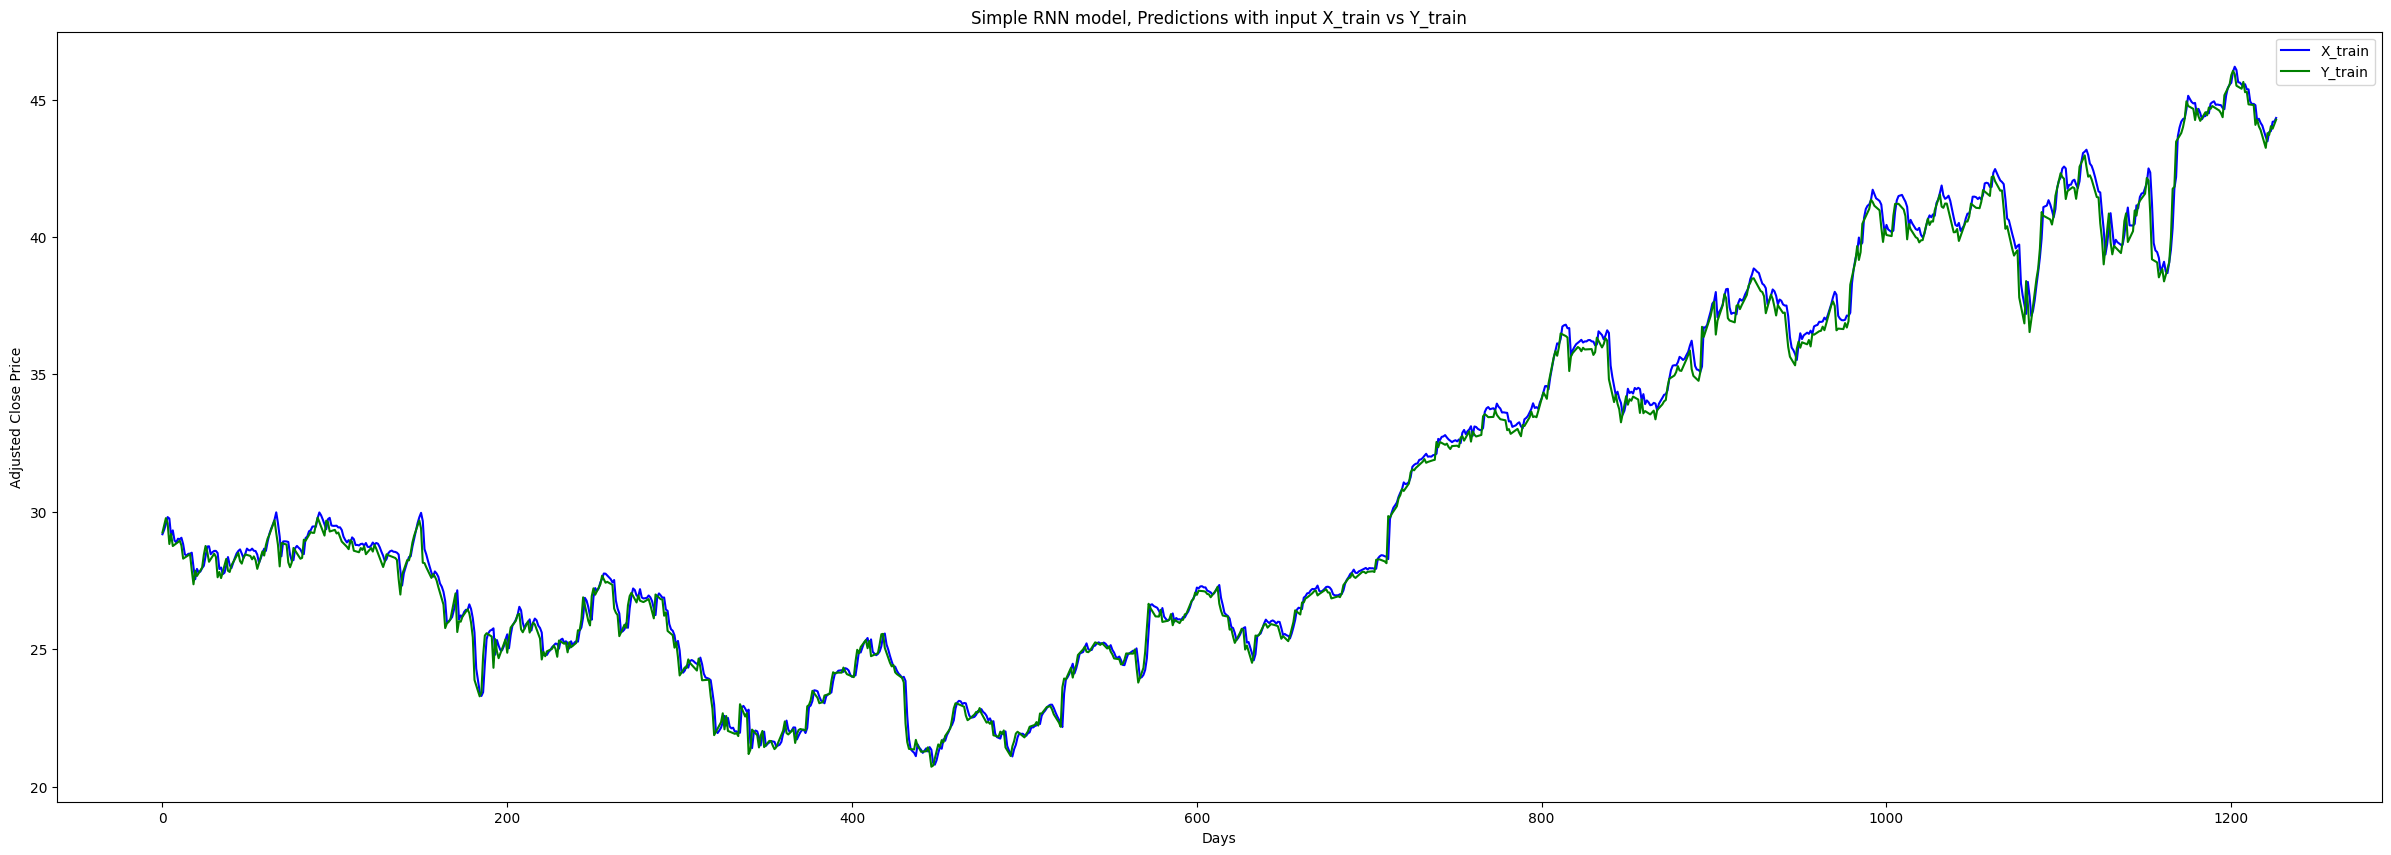

In [54]:
# Visualising training dataset
plt.figure(figsize = (30,10))
plt.plot(Y_pred_train, color = "b", label = "X_train" )
plt.plot(Y_train, color = "g", label = "Y_train")
plt.xlabel("Days")
plt.ylabel("Adjusted Close Price")
plt.title("Simple RNN model, Predictions with input X_train vs Y_train")
plt.legend()
plt.show()

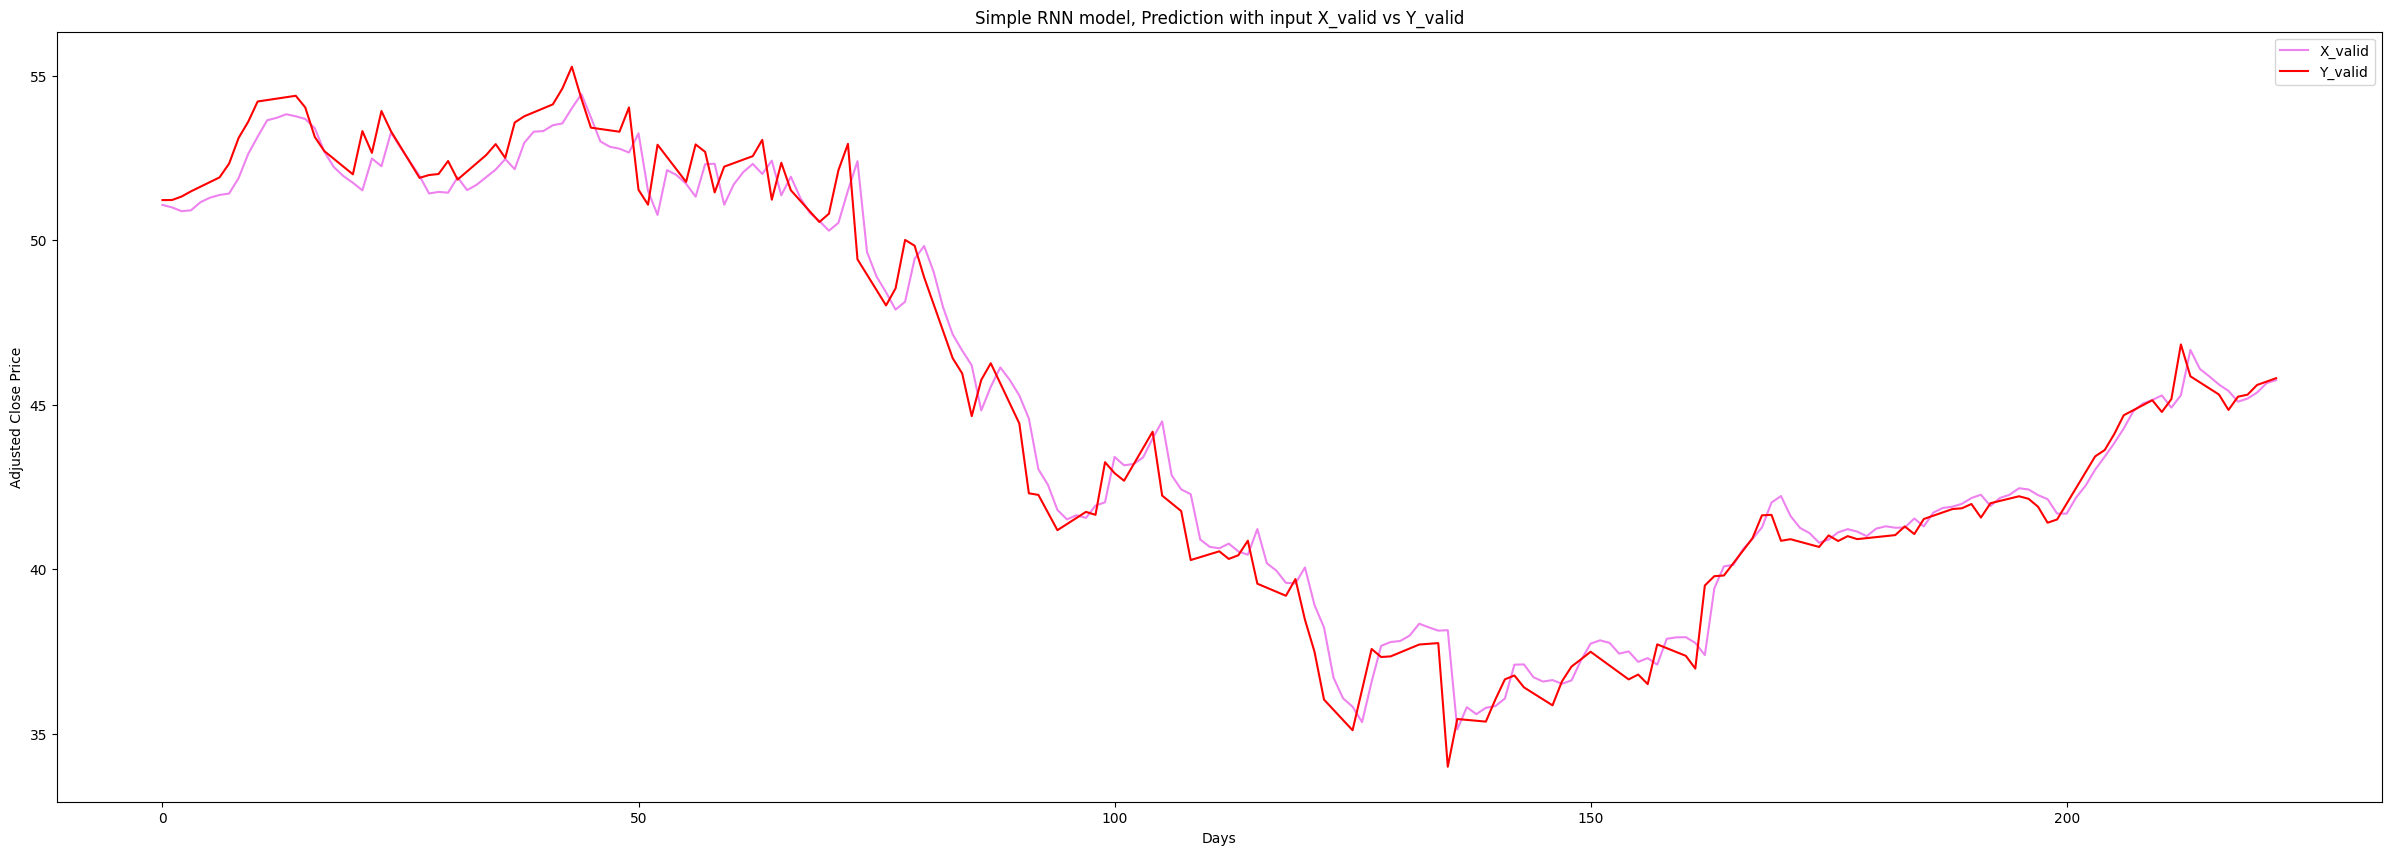

In [55]:
# Visualising validation dataset
plt.figure(figsize = (30,10))
plt.plot(Y_pred_valid, label = "X_valid", c = "violet")
plt.plot(Y_valid, label = "Y_valid", c = "red")
plt.xlabel("Days")
plt.ylabel("Adjusted Close Price")
plt.title("Simple RNN model, Prediction with input X_valid vs Y_valid")
plt.legend()
plt.show()

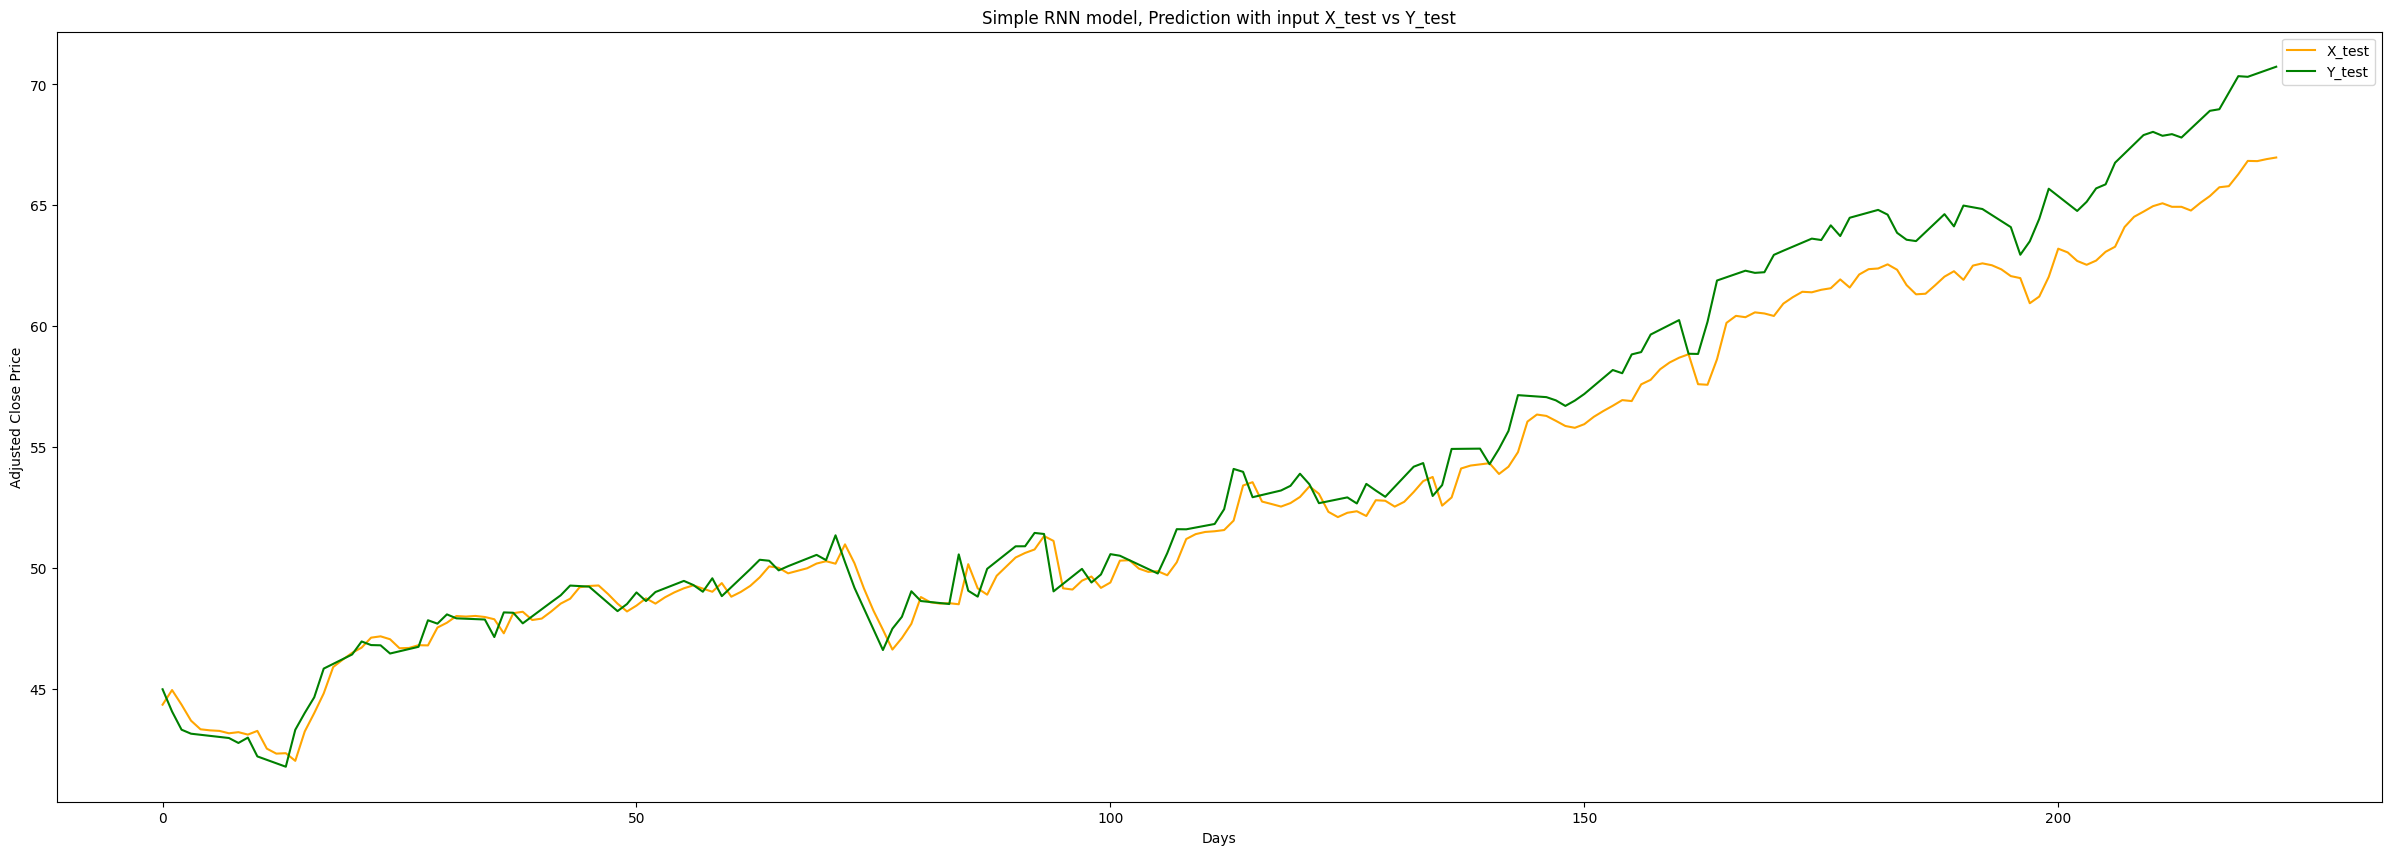

In [56]:
# Visualising testing dataset
plt.figure(figsize = (30,10))
plt.plot(Y_test_pred, label = "X_test", c = "orange")
plt.plot(Y_test, label = "Y_test", c = "g")
plt.xlabel("Days")
plt.ylabel("Adjusted Close Price")
plt.title("Simple RNN model, Prediction with input X_test vs Y_test")
plt.legend()
plt.show()

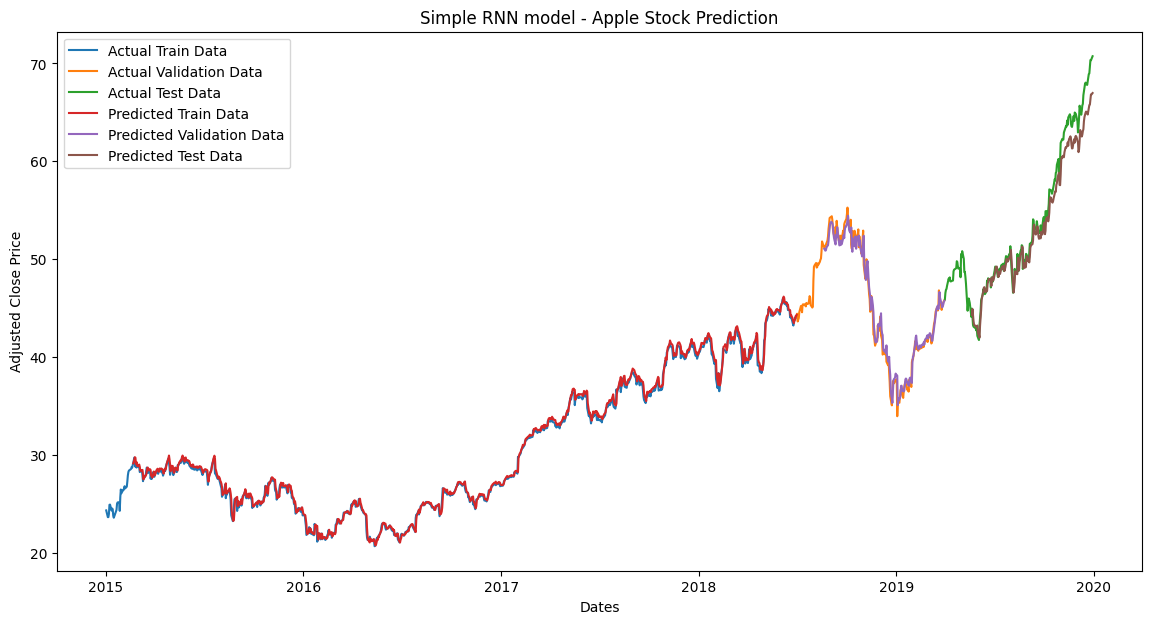

In [57]:
# Visualisation for Apple stock prediction
plt.subplots(figsize =(14,7))
plt.plot(train_hist_data_close_values.index ,train_hist_data_close_values, label = "Actual Train Data")
plt.plot(valid_hist_data_close_values.index ,valid_hist_data_close_values, label = "Actual Validation Data")
plt.plot(test_hist_data_close_values.index, test_hist_data_close_values, label = "Actual Test Data",)
plt.plot(train_hist_data_close_values.index[time_step:], Y_pred_train, label = "Predicted Train Data")
plt.plot(valid_hist_data_close_values.index[time_step:], Y_pred_valid, label = "Predicted Validation Data")
plt.plot(test_hist_data_close_values.index[time_step:], Y_test_pred, label = "Predicted Test Data")
plt.xlabel("Dates")
plt.ylabel("Adjusted Close Price")
plt.title("Simple RNN model - Apple Stock Prediction")
plt.legend()
plt.show()